In [2]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
import hvplot.polars
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

option_data = Path.cwd().parent.parent / "Data/Option_data/sso_new.csv"
df = pl.scan_csv(option_data, separator=",")


parquet_file = (Path.cwd().parent / "Data/Option_data/sso_new")

data_path = Path.cwd().parent / "Data"

#Restrictions
timeperiod = [datetime.datetime(2019, 1, 1), datetime.datetime(2021, 12, 31)]
volume_r = 0
open_interest_r = 0
delta_r = 0
vega_r = 0
theta_r = 0
gamma_r = 0
midprice_r = 0.3
bid_price_r = 0.0
days_till_exp_r1 = 7
days_till_exp_r2 = 252
moneyness_min = 0.8
moneyness_max = 1.6
price_min = 0.125

# Lower the data by use of efficiency and formatting

In [3]:
#Desired data types for the columns
int_cols = ["strike_price", "volume", "open_interest"]
float_cols = ["best_bid", "best_offer", "impl_volatility", "delta", "gamma", "vega", "theta"]
datetime_cols = ["date","exdate"]
str_cols = ["cp_flag", "ticker", "exercise_style"]
drop_cols = ["optionid", "index_flag", "issuer", "div_convention", "exercise_style"]

In [4]:
#one line to do all the above
existing_str_cols = [col for col in str_cols if col in df.columns]

df = df.with_columns(
    [ pl.col(int_cols).cast(pl.Int64),
      pl.col(float_cols).cast(pl.Float64),
      pl.col(datetime_cols).cast(pl.Date),
      pl.col(existing_str_cols).cast(pl.String),
    ]
).drop(drop_cols)

## Apply filter for volume and open interest

In [5]:
# Saving file
data_path_parq = Path.cwd().parent.parent / "Data/Option_data/sso_complete.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_path_parq):
    df.sink_parquet(data_path_parq)

In [6]:
df = pl.read_parquet(data_path_parq)

# Applying the different filters 
- Time period from 2019 - 2022
- 0 to 7 days experiy
- moneyness from 0.8 to 1.2

In [7]:
df

date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker
date,date,str,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,str
2016-01-04,2016-01-08,"""C""",1000000,0.0,0.49,0,0,1.692439,0.006994,0.000173,1.300576,-100.3955,"""AMZN"""
2016-01-04,2016-01-08,"""C""",400000,234.75,238.15,0,0,null,null,null,null,null,"""AMZN"""
2016-01-04,2016-01-08,"""C""",410000,224.5,228.2,0,0,null,null,null,null,null,"""AMZN"""
2016-01-04,2016-01-08,"""C""",420000,214.75,218.3,0,0,null,null,null,null,null,"""AMZN"""
2016-01-04,2016-01-08,"""C""",430000,204.35,208.3,0,0,null,null,null,null,null,"""AMZN"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-01-31,2024-01-19,"""P""",580000,267.25,270.55,0,1,0.333331,-0.905684,0.002077,66.00584,-3.643168,"""META"""
2022-01-31,2024-01-19,"""P""",590000,277.1,280.3,0,3,0.337186,-0.91153,0.002044,63.58122,-3.560699,"""META"""
2022-01-31,2024-01-19,"""P""",600000,286.55,290.2,0,38,0.338903,-0.919997,0.002023,62.99949,-3.386516,"""META"""


In [8]:
# # Creating the date filter period
31

# Creating the date filter period
# df = df.filter(
#     pl.col("exdate").is_between(timeperiod[0], timeperiod[1]),
# )
# df = df.filter(
#     pl.col("date").is_between(timeperiod[0], timeperiod[1]),
# )

31

In [9]:
dfp = df.to_pandas()

dfp['prc_option'] = (dfp['best_offer'] + dfp['best_bid']) / 2

# Create a custom business day object that excludes weekends and US federal holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Calculate the number of business days between 'date' and 'exdate'
def business_days_diff(start_date, end_date, business_day_offset):
    return np.busday_count(start_date.date(), end_date.date(), busdaycal=business_day_offset.holidays)

# Get US federal holidays within the range
holidays = USFederalHolidayCalendar().holidays(start=dfp['date'].min(), end=dfp['exdate'].max())

# Convert holidays to numpy datetime64 array
holidays = holidays.to_numpy(dtype='datetime64[D]')

# Calculate the difference in business days for each row
dfp['trading_days_till_exp'] = np.busday_count(dfp['date'].values.astype('datetime64[D]'),
                                               dfp['exdate'].values.astype('datetime64[D]'),
                                               holidays=holidays)


In [10]:
df = pl.from_pandas(dfp)


df = df.filter(pl.col("trading_days_till_exp") <= days_till_exp_r2)

# #Creating a filter for the volume and open_interest
df = df.filter((pl.col("volume") > volume_r))

# #Create filter for bid higher than ask price
df = df.filter(pl.col("best_bid") <= pl.col("best_offer"))
df = df.filter(pl.col("best_bid") >= bid_price_r)

# Filter out rows where 'impl_volatility' is missing
df = df.filter(pl.col("impl_volatility").is_not_null())

# df = df.filter((pl.col("prc_option") > price_min))





In [11]:
df

date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,prc_option,trading_days_till_exp
datetime[ms],datetime[ms],str,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,str,f64,i64
2016-01-04 00:00:00,2016-01-08 00:00:00,"""C""",580000,56.75,57.45,11,0,0.386271,0.99036,0.001004,1.725157,-32.63219,"""AMZN""",57.1,4
2016-01-04 00:00:00,2016-01-08 00:00:00,"""C""",590000,47.3,48.0,11,0,0.450882,0.950334,0.003414,6.839587,-142.9916,"""AMZN""",47.65,4
2016-01-04 00:00:00,2016-01-08 00:00:00,"""C""",595000,42.55,43.4,39,0,0.450541,0.929264,0.004507,9.033681,-187.763,"""AMZN""",42.975,4
2016-01-04 00:00:00,2016-01-08 00:00:00,"""C""",600000,38.25,38.8,83,8,0.458482,0.898159,0.005818,11.86455,-250.2119,"""AMZN""",38.525,4
2016-01-04 00:00:00,2016-01-08 00:00:00,"""C""",605000,33.6,34.2,21,0,0.439795,0.873458,0.007081,13.8338,-279.9032,"""AMZN""",33.9,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-01-31 00:00:00,2023-01-20 00:00:00,"""P""",410000,105.85,107.15,1,448,0.314054,-0.764195,0.003357,94.55447,-13.4987,"""META""",106.5,243
2022-01-31 00:00:00,2023-01-20 00:00:00,"""P""",435000,127.05,128.55,1,235,0.30952,-0.827501,0.002927,77.56268,-10.68491,"""META""",127.8,243
2022-01-31 00:00:00,2023-01-20 00:00:00,"""P""",440000,131.7,133.4,1,180,0.313266,-0.833656,0.002837,76.04378,-10.53336,"""META""",132.55,243


## Create a graph of the days till expiry and implied volatility of a specific stock for a strike price

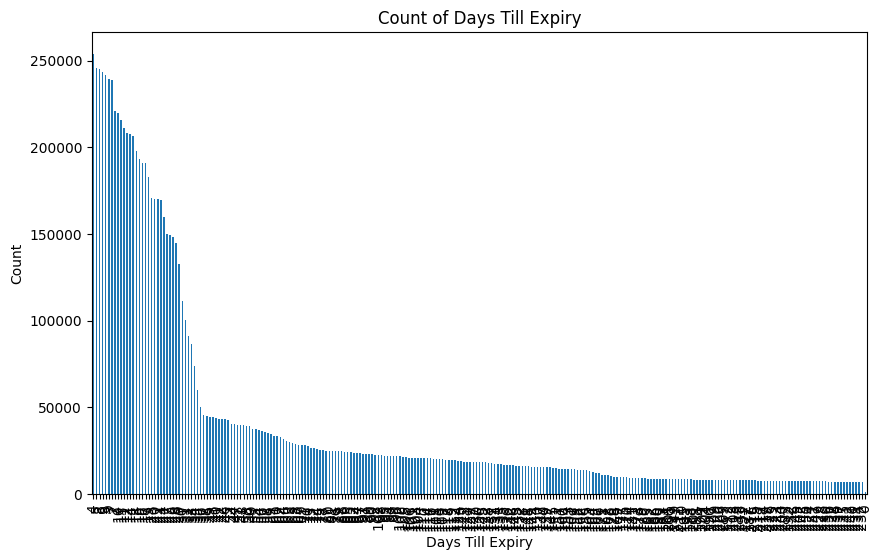

In [12]:
# Get the counts of 'days_till_exp'
df_pandas = df.to_pandas()

counts = df_pandas['trading_days_till_exp'].value_counts()

# Create the bar plot
counts.plot(kind='bar', figsize=(10, 6))
plt.title('Count of Days Till Expiry')
plt.xlabel('Days Till Expiry')
plt.ylabel('Count')
plt.show()

# Merging the stock prices with the options

In [13]:
merged_df = df

In [14]:
# Reading the stock data
stock_path_parq = Path.cwd().parent.parent / "Data/Stock_data/stock_data_new.parquet"
df_stock1 = pl.read_parquet(stock_path_parq)

# Convert Polars dataframes to pandas
df = merged_df.to_pandas()
df_stock = df_stock1.to_pandas()

# Ensure that 'date' is a datetime object in both dataframes
df['date'] = pd.to_datetime(df['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])

# Rename the 'TICKER' column in df_stock to 'ticker' to match df
df_stock = df_stock.rename(columns={'TICKER': 'ticker'})

# Merge 'RET' column from df_stock into df
merged_df = pd.merge(df, df_stock[['ticker', 'date', 'PRC', 'PRC_actual', 'BIDLO', 'ASKHI']], on=['ticker', 'date'], how='left')


In [15]:
import pandas as pd

# Complete data in list format for all 6 tickers
data = [
    # MSFT
    {"date": "2022-01-03", "ticker": "MSFT", "PERMCO": 8048, "BIDLO": None, "ASKHI": 329.78, "VOL": 338.0, "RET": 28823566, "bid": 334.73001, "ask": 334.73999, "RETX": -0.00466},
    {"date": "2022-01-04", "ticker": "MSFT", "PERMCO": 8048, "BIDLO": None, "ASKHI": 326.12, "VOL": 335.2, "RET": 32626156, "bid": 329.04001, "ask": 329.06, "RETX": -0.01714},
    {"date": "2022-01-05", "ticker": "MSFT", "PERMCO": 8048, "BIDLO": None, "ASKHI": 315.98001, "VOL": 326.07, "RET": 39957778, "bid": 316.20001, "ask": 316.42001, "RETX": -0.03838},
    {"date": "2022-01-06", "ticker": "MSFT", "PERMCO": 8048, "BIDLO": None, "ASKHI": 311.49, "VOL": 318.7, "RET": 39744069, "bid": 313.84, "ask": 313.88, "RETX": -0.0079},
    {"date": "2022-01-07", "ticker": "MSFT", "PERMCO": 8048, "BIDLO": None, "ASKHI": 310.09, "VOL": 316.5, "RET": 32664078, "bid": 314.01999, "ask": 314.10999, "RETX": 0.00051},
    {"date": "2022-01-10", "ticker": "MSFT", "PERMCO": 8048, "BIDLO": None, "ASKHI": 304.69, "VOL": 314.72, "RET": 44236612, "bid": 314.09, "ask": 314.54001, "RETX": 0.00073},
    # FB (to be renamed to META)
    {"date": "2022-01-03", "ticker": "FB", "PERMCO": 54084, "BIDLO": None, "ASKHI": 337.19, "VOL": 341.0816, "RET": 14521724, "bid": 338.48001, "ask": 338.63, "RETX": 0.00651},
    {"date": "2022-01-04", "ticker": "FB", "PERMCO": 54084, "BIDLO": None, "ASKHI": 331.87109, "VOL": 343.08539, "RET": 15926607, "bid": 336.5, "ask": 336.51001, "RETX": -0.00593},
    {"date": "2022-01-05", "ticker": "FB", "PERMCO": 54084, "BIDLO": None, "ASKHI": 323.84, "VOL": 335.76001, "RET": 20506237, "bid": 323.95999, "ask": 324.19, "RETX": -0.03672},
    {"date": "2022-01-06", "ticker": "FB", "PERMCO": 54084, "BIDLO": None, "ASKHI": 322.72, "VOL": 339.16501, "RET": 27855944, "bid": 332.5, "ask": 332.54001, "RETX": 0.02557},
    {"date": "2022-01-07", "ticker": "FB", "PERMCO": 54084, "BIDLO": None, "ASKHI": 328.8801, "VOL": 337.0, "RET": 14656798, "bid": 331.69, "ask": 331.73999, "RETX": -0.00201},
    {"date": "2022-01-10", "ticker": "FB", "PERMCO": 54084, "BIDLO": None, "ASKHI": 315.42999, "VOL": 328.34, "RET": 24859449, "bid": 328.07001, "ask": 328.17001, "RETX": -0.01121},
    # AAPL
    {"date": "2022-01-03", "ticker": "AAPL", "PERMCO": 7, "BIDLO": None, "ASKHI": 177.71, "VOL": 182.88, "RET": 104656435, "bid": 182.0, "ask": 182.00999, "RETX": 0.025},
    {"date": "2022-01-04", "ticker": "AAPL", "PERMCO": 7, "BIDLO": None, "ASKHI": 179.12, "VOL": 182.94, "RET": 99155535, "bid": 179.66, "ask": 179.71001, "RETX": -0.01269},
    {"date": "2022-01-05", "ticker": "AAPL", "PERMCO": 7, "BIDLO": None, "ASKHI": 174.64, "VOL": 180.17, "RET": 94423171, "bid": 174.78, "ask": 174.89999, "RETX": -0.0266},
    {"date": "2022-01-06", "ticker": "AAPL", "PERMCO": 7, "BIDLO": None, "ASKHI": 171.64, "VOL": 175.3, "RET": 96820640, "bid": 172.0, "ask": 172.00999, "RETX": -0.01669},
    {"date": "2022-01-07", "ticker": "AAPL", "PERMCO": 7, "BIDLO": None, "ASKHI": 171.03, "VOL": 174.14, "RET": 87650955, "bid": 172.19, "ask": 172.25, "RETX": 0.00098},
    {"date": "2022-01-10", "ticker": "AAPL", "PERMCO": 7, "BIDLO": None, "ASKHI": 168.17, "VOL": 172.5, "RET": 106792948, "bid": 172.16, "ask": 172.21001, "RETX": 0.00011},
    # AMZN
    {"date": "2022-01-03", "ticker": "AMZN", "PERMCO": 15473, "BIDLO": None, "ASKHI": 3323.20996, "VOL": 3414.07007, "RET": 3170057, "bid": 3407.1499, "ask": 3408.3999, "RETX": 0.02118},
    {"date": "2022-01-04", "ticker": "AMZN", "PERMCO": 15473, "BIDLO": None, "ASKHI": 3326.98999, "VOL": 3428.0, "RET": 3503967, "bid": 3349.03003, "ask": 3350.40991, "RETX": -0.06916},
    {"date": "2022-01-05", "ticker": "AMZN", "PERMCO": 15473, "BIDLO": None, "ASKHI": 3287.13989, "VOL": 3342.5249, "RET": 3189163, "bid": 3287.62012, "ask": 3288.01001, "RETX": -0.08893},
    {"date": "2022-01-06", "ticker": "AMZN", "PERMCO": 15473, "BIDLO": None, "ASKHI": 3238.74414, "VOL": 3296.0, "RET": 2572225, "bid": 3264.5, "ask": 3265.08008, "RETX": -0.06711},
    {"date": "2022-01-07", "ticker": "AMZN", "PERMCO": 15473, "BIDLO": None, "ASKHI": 3240.62012, "VOL": 3304.86499, "RET": 2305102, "bid": 3251.0, "ask": 3252.12988, "RETX": -0.04288},
    {"date": "2022-01-10", "ticker": "AMZN", "PERMCO": 15473, "BIDLO": None, "ASKHI": 3126.09009, "VOL": 3233.22998, "RET": 4359012, "bid": 3229.33008, "ask": 3230.57007, "RETX": -0.0657},
    # TSLA
    {"date": "2022-01-03", "ticker": "TSLA", "PERMCO": 53453, "BIDLO": None, "ASKHI": 1136.04004, "VOL": 1201.06995, "RET": 34704012, "bid": 1199.51001, "ask": 1199.65002, "RETX": 0.15317},
    {"date": "2022-01-04", "ticker": "TSLA", "PERMCO": 53453, "BIDLO": None, "ASKHI": 1123.05005, "VOL": 1208.00000, "RET": 33232066, "bid": 1149.40002, "ask": 1149.58997, "RETX": -0.41833},
    {"date": "2022-01-05", "ticker": "TSLA", "PERMCO": 53453, "BIDLO": None, "ASKHI": 1081.01013, "VOL": 1170.33997, "RET": 26527233, "bid": 1087.62000, "ask": 1087.98999, "RETX": -0.53471},
    {"date": "2022-01-06", "ticker": "TSLA", "PERMCO": 53453, "BIDLO": None, "ASKHI": 1020.50000, "VOL": 1088.00000, "RET": 30094321, "bid": 1064.69995, "ask": 1064.98999, "RETX": -0.21523},
    {"date": "2022-01-07", "ticker": "TSLA", "PERMCO": 53453, "BIDLO": None, "ASKHI": 1010.00000, "VOL": 1080.92993, "RET": 27919584, "bid": 1026.87000, "ask": 1027.10999, "RETX": -0.35447},
    {"date": "2022-01-10", "ticker": "TSLA", "PERMCO": 53453, "BIDLO": None, "ASKHI": 980.00000, "VOL": 1059.09998, "RET": 30455813, "bid": 1058.31995, "ask": 1058.46997, "RETX": 0.03342},
    # NVDA
    {"date": "2022-01-03", "ticker": "NVDA", "PERMCO": 16382, "BIDLO": None, "ASKHI": 297.85001, "VOL": 307.10999, "RET": 39169873, "bid": 301.16000, "ask": 301.25000, "RETX": 0.02414},
    {"date": "2022-01-04", "ticker": "NVDA", "PERMCO": 16382, "BIDLO": None, "ASKHI": 283.48999, "VOL": 304.67999, "RET": 52604303, "bid": 292.88000, "ask": 292.98999, "RETX": -0.02759},
    {"date": "2022-01-05", "ticker": "NVDA", "PERMCO": 16382, "BIDLO": None, "ASKHI": 275.32999, "VOL": 294.16000, "RET": 49676779, "bid": 275.95999, "ask": 275.98999, "RETX": -0.05752},
    {"date": "2022-01-06", "ticker": "NVDA", "PERMCO": 16382, "BIDLO": None, "ASKHI": 270.64999, "VOL": 284.37991, "RET": 45277552, "bid": 281.78000, "ask": 281.79999, "RETX": 0.02079},
    {"date": "2022-01-07", "ticker": "NVDA", "PERMCO": 16382, "BIDLO": None, "ASKHI": 270.57001, "VOL": 284.22000, "RET": 40945228, "bid": 272.32001, "ask": 272.47000, "RETX": -0.03300},
    {"date": "2022-01-10", "ticker": "NVDA", "PERMCO": 16382, "BIDLO": None, "ASKHI": 256.43839, "VOL": 274.69000, "RET": 59336455, "bid": 274.17001, "ask": 274.17999, "RETX": 0.00561},
]

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate stock price as (bid + ask) / 2
df["price"] = (df["bid"] + df["ask"]) / 2

# Change "FB" to "META"
df["ticker"] = df["ticker"].replace("FB", "META")

# Display the DataFrame
df_new = df[['date', 'ticker', 'price']]
df_new


,date,ticker,price
0,2022-01-03,MSFT,334.735000
1,2022-01-04,MSFT,329.050005
2,2022-01-05,MSFT,316.310010
3,2022-01-06,MSFT,313.860000
4,2022-01-07,MSFT,314.064990
5,2022-01-10,MSFT,314.315005
6,2022-01-03,META,338.555005
7,2022-01-04,META,336.505005
8,2022-01-05,META,324.074995
9,2022-01-06,META,332.520005


In [16]:
merged_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,prc_option,trading_days_till_exp,PRC,PRC_actual,BIDLO,ASKHI
0,2016-01-04,2016-01-08,C,580000,56.75,57.45,11,0,0.386271,0.990360,0.001004,1.725157,-32.632190,AMZN,57.100,4,NaN,NaN,NaN,NaN
1,2016-01-04,2016-01-08,C,590000,47.30,48.00,11,0,0.450882,0.950334,0.003414,6.839587,-142.991600,AMZN,47.650,4,NaN,NaN,NaN,NaN
2,2016-01-04,2016-01-08,C,595000,42.55,43.40,39,0,0.450541,0.929264,0.004507,9.033681,-187.763000,AMZN,42.975,4,NaN,NaN,NaN,NaN
3,2016-01-04,2016-01-08,C,600000,38.25,38.80,83,8,0.458482,0.898159,0.005818,11.864550,-250.211900,AMZN,38.525,4,NaN,NaN,NaN,NaN
4,2016-01-04,2016-01-08,C,605000,33.60,34.20,21,0,0.439795,0.873458,0.007081,13.833800,-279.903200,AMZN,33.900,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10130037,2022-01-31,2023-01-20,P,410000,105.85,107.15,1,448,0.314054,-0.764195,0.003357,94.554470,-13.498700,META,106.500,243,NaN,NaN,NaN,NaN
10130038,2022-01-31,2023-01-20,P,435000,127.05,128.55,1,235,0.309520,-0.827501,0.002927,77.562680,-10.684910,META,127.800,243,NaN,NaN,NaN,NaN
10130039,2022-01-31,2023-01-20,P,440000,131.70,133.40,1,180,0.313266,-0.833656,0.002837,76.043780,-10.533360,META,132.550,243,NaN,NaN,NaN,NaN
10130040,2022-01-31,2023-01-20,P,445000,135.90,137.90,1,226,0.311318,-0.845660,0.002747,72.203990,-9.872270,META,136.900,243,NaN,NaN,NaN,NaN


In [17]:
# Ensure prices_df contains the necessary columns

# Iterate through the calculated prices and update only the missing PRC values in merged_df
for _, row in df_new.iterrows():
    # Identify rows in merged_df with matching date and ticker, and missing PRC
    mask = (merged_df['date'] == row['date']) & (merged_df['ticker'] == row['ticker']) & (merged_df['PRC'].isna())
    # Update the PRC value
    merged_df.loc[mask, 'PRC'] = row['price']

# Display the updated DataFrame
(merged_df)


,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,prc_option,trading_days_till_exp,PRC,PRC_actual,BIDLO,ASKHI
0,2016-01-04,2016-01-08,C,580000,56.75,57.45,11,0,0.386271,0.990360,0.001004,1.725157,-32.632190,AMZN,57.100,4,NaN,NaN,NaN,NaN
1,2016-01-04,2016-01-08,C,590000,47.30,48.00,11,0,0.450882,0.950334,0.003414,6.839587,-142.991600,AMZN,47.650,4,NaN,NaN,NaN,NaN
2,2016-01-04,2016-01-08,C,595000,42.55,43.40,39,0,0.450541,0.929264,0.004507,9.033681,-187.763000,AMZN,42.975,4,NaN,NaN,NaN,NaN
3,2016-01-04,2016-01-08,C,600000,38.25,38.80,83,8,0.458482,0.898159,0.005818,11.864550,-250.211900,AMZN,38.525,4,NaN,NaN,NaN,NaN
4,2016-01-04,2016-01-08,C,605000,33.60,34.20,21,0,0.439795,0.873458,0.007081,13.833800,-279.903200,AMZN,33.900,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10130037,2022-01-31,2023-01-20,P,410000,105.85,107.15,1,448,0.314054,-0.764195,0.003357,94.554470,-13.498700,META,106.500,243,NaN,NaN,NaN,NaN
10130038,2022-01-31,2023-01-20,P,435000,127.05,128.55,1,235,0.309520,-0.827501,0.002927,77.562680,-10.684910,META,127.800,243,NaN,NaN,NaN,NaN
10130039,2022-01-31,2023-01-20,P,440000,131.70,133.40,1,180,0.313266,-0.833656,0.002837,76.043780,-10.533360,META,132.550,243,NaN,NaN,NaN,NaN
10130040,2022-01-31,2023-01-20,P,445000,135.90,137.90,1,226,0.311318,-0.845660,0.002747,72.203990,-9.872270,META,136.900,243,NaN,NaN,NaN,NaN


## Create the forward price of the stocks

In [18]:
# Load the existing firm and market data
df_firm = merged_df  # Replace with your path
df_macro = pd.read_parquet(Path.cwd().parent.parent / "Data/Macroeconomic_variables/merged_marcofirm.parquet")  # Replace with your path

# Load the dividend data
df_dividends = pd.read_csv(Path.cwd().parent.parent / 'Data/Stock_data/Dividend_Data_2019_2022.csv')  # Replace with your path

# Convert the DATE column to datetime format for easy merging
df_macro['DATE'] = pd.to_datetime(df_macro['DATE'])

# Calculate the annual dividend yield by grouping by ticker and summing the dividends per year
df_dividends['Date'] = pd.to_datetime(df_dividends['Date'])
df_dividends['Year'] = df_dividends['Date'].dt.year
annual_dividends = df_dividends.groupby(['Ticker', 'Year'])['Amount'].sum().reset_index()
annual_dividends['Annual_Dividend_Yield'] = annual_dividends['Amount'] / df_firm['PRC']

# Merge the annual dividend yield back to the firm data
df_firm['Year'] = df_firm['date'].dt.year
df_firm = df_firm.rename(columns={'ticker': 'Ticker'})
df_firm = df_firm.merge(annual_dividends[['Ticker', 'Year', 'Annual_Dividend_Yield']], 
                        on=['Ticker', 'Year'], how='left')

# Fill NaN values in 'Annual_Dividend_Yield' with 0
df_firm['Annual_Dividend_Yield'] = df_firm['Annual_Dividend_Yield'].fillna(0)

# Calculate time to maturity in years
df_firm['T'] = df_firm['trading_days_till_exp'] / 252

# Interpolate the 2Y bond rates for exact dates of the firm data
df_firm['DATE'] = df_firm['date']
df_firm = df_firm.merge(df_macro[['DATE', '2Y_bond']], on='DATE', how='left')
df_firm['2Y_bond'].interpolate(method='time', inplace=True)

# Convert '2Y_bond' and 'Annual_Dividend_Yield' to float
df_firm['2Y_bond'] = df_firm['2Y_bond'].astype(float)
df_firm['Annual_Dividend_Yield'] = df_firm['Annual_Dividend_Yield'].astype(float)

# Calculate forward prices using the formula F = P * e^(r - q)T
df_firm['Forward_Price'] = df_firm['PRC'] * np.exp(((df_firm['2Y_bond']/100) - df_firm['Annual_Dividend_Yield']) * df_firm['T'])

# Save the updated dataframe with the Forward Price column
# updated_file_path = "/mnt/data/Updated_Firm_Data.csv"
# df_firm.to_csv(updated_file_path, index=False)


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11897/3996837785.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_firm['2Y_bond'].interpolate(method='time', inplace=True)
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11897/3996837785.py:32: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_firm['2Y_bond'].interpolate(method='time', inplace=True)


## Create the moneyness column

In [19]:
merged_df = df_firm

In [20]:
merged_df['moneyness'] = ((merged_df['PRC']) / (merged_df['strike_price']/1000))

merged_df[['date', 'cp_flag', 'Ticker', 'strike_price', 'PRC', 'trading_days_till_exp', 'moneyness', 'prc_option', 'BIDLO', 'ASKHI']]

,date,cp_flag,Ticker,strike_price,PRC,trading_days_till_exp,moneyness,prc_option,BIDLO,ASKHI
0,2016-01-04,C,AMZN,580000,NaN,4,NaN,57.100,NaN,NaN
1,2016-01-04,C,AMZN,590000,NaN,4,NaN,47.650,NaN,NaN
2,2016-01-04,C,AMZN,595000,NaN,4,NaN,42.975,NaN,NaN
3,2016-01-04,C,AMZN,600000,NaN,4,NaN,38.525,NaN,NaN
4,2016-01-04,C,AMZN,605000,NaN,4,NaN,33.900,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10130037,2022-01-31,P,META,410000,NaN,243,NaN,106.500,NaN,NaN
10130038,2022-01-31,P,META,435000,NaN,243,NaN,127.800,NaN,NaN
10130039,2022-01-31,P,META,440000,NaN,243,NaN,132.550,NaN,NaN
10130040,2022-01-31,P,META,445000,NaN,243,NaN,136.900,NaN,NaN


## Create the trading_day column

In [21]:
# Sort the DataFrame by date
merged_df = merged_df.sort_values('date')

# Create a new column 'trading_day' that ranks each unique date
merged_df['trading_day'] = merged_df['date'].rank(method='dense').astype(int)

In [22]:
stock_aapl = merged_df[merged_df['Ticker'] == 'AAPL']
stock_aapl

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,BIDLO,ASKHI,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,moneyness,trading_day
213487,2016-01-04,2016-10-21,P,97500,7.00,7.05,67,289,0.282882,-0.341347,...,NaN,NaN,2016,0.0,0.805556,2016-01-04,NaN,NaN,NaN,1
213054,2016-01-04,2016-01-22,C,105000,2.75,2.79,1923,586,0.283610,0.528150,...,NaN,NaN,2016,0.0,0.051587,2016-01-04,NaN,NaN,NaN,1
213053,2016-01-04,2016-01-22,C,104000,3.30,3.45,568,144,0.291433,0.586616,...,NaN,NaN,2016,0.0,0.051587,2016-01-04,NaN,NaN,NaN,1
213052,2016-01-04,2016-01-22,C,103000,3.95,4.20,680,63,0.303918,0.639203,...,NaN,NaN,2016,0.0,0.051587,2016-01-04,NaN,NaN,NaN,1
213051,2016-01-04,2016-01-22,C,100000,6.20,6.40,2764,319,0.324789,0.773704,...,NaN,NaN,2016,0.0,0.051587,2016-01-04,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974877,2022-01-31,2022-06-17,C,97500,77.55,77.85,12,4972,0.517898,0.976582,...,NaN,NaN,2022,0.0,0.384921,2022-01-31,NaN,NaN,NaN,1531
9974876,2022-01-31,2022-06-17,C,95000,80.00,80.30,210,6639,0.529404,0.978823,...,NaN,NaN,2022,0.0,0.384921,2022-01-31,NaN,NaN,NaN,1531
9974875,2022-01-31,2022-06-17,C,92500,82.45,82.75,5,2363,0.540346,0.980973,...,NaN,NaN,2022,0.0,0.384921,2022-01-31,NaN,NaN,NaN,1531
9974874,2022-01-31,2022-06-17,C,90000,84.90,85.20,5,3868,0.550289,0.983191,...,NaN,NaN,2022,0.0,0.384921,2022-01-31,NaN,NaN,NaN,1531


# Create a few filters for the dataframe and an overview

In [23]:
#Create moneyness filter
pl_merged = pl.from_pandas(merged_df)

pl_merged = pl_merged.filter((pl.col("moneyness") >= moneyness_min) & (pl.col("moneyness") <= moneyness_max))

pd_merged = pl_merged.to_pandas()


In [24]:
import pandas as pd
import plotly.graph_objects as go

# Create a copy of pd_merged
pd_merged_copy = pd_merged.copy()

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-03')

# Use the copy for the filtering
pd_merged_2 = pd_merged_copy[(pd_merged_copy["trading_days_till_exp"] <= 10) & (pd_merged_copy['cp_flag'] == 'P')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df_nvda = pd_merged_2[(pd_merged_2['Ticker'] == 'AMZN') & (pd_merged_2['date'] == date)]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_nvda['moneyness'],
    y=df_nvda['trading_days_till_exp'],
    z=df_nvda['impl_volatility'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_nvda['impl_volatility'],  # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading Days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [30]:
null_vals = pd_merged[(pd_merged['prc_option'] <= 1/8)]
null_vals 

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,BIDLO,ASKHI,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,moneyness,trading_day
138,2018-12-31,2019-01-04,P,95000,0.00,0.01,1,390,1.034486,-0.001219,...,132.2,135.92,2018,0.0,0.011905,2018-12-31,2.5442,133.240350,1.402105,754
139,2018-12-31,2019-01-04,P,90000,0.00,0.01,48,265,1.194794,-0.001063,...,132.2,135.92,2018,0.0,0.011905,2018-12-31,2.5442,133.240350,1.480000,754
144,2018-12-31,2019-01-04,P,85000,0.00,0.02,5,1073,1.449432,-0.001675,...,132.2,135.92,2018,0.0,0.011905,2018-12-31,2.5442,133.240350,1.567059,754
176,2018-12-31,2019-01-11,P,105000,0.10,0.12,100,58,0.626653,-0.020181,...,132.2,135.92,2018,0.0,0.031746,2018-12-31,2.5442,133.307627,1.268571,754
177,2018-12-31,2019-01-11,P,100000,0.05,0.07,75,466,0.684736,-0.010818,...,132.2,135.92,2018,0.0,0.031746,2018-12-31,2.5442,133.307627,1.332000,754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225862,2022-01-10,2022-01-14,C,385000,0.00,0.02,32,3046,0.524243,0.001937,...,NaN,NaN,2022,0.0,0.015873,2022-01-10,NaN,NaN,0.852260,1517
5225863,2022-01-10,2022-01-14,C,390000,0.00,0.02,38,304,0.562291,0.001818,...,NaN,NaN,2022,0.0,0.015873,2022-01-10,NaN,NaN,0.841333,1517
5225864,2022-01-10,2022-01-14,C,400000,0.00,0.01,5,250,0.600677,0.000901,...,NaN,NaN,2022,0.0,0.015873,2022-01-10,NaN,NaN,0.820300,1517
5225865,2022-01-10,2022-01-14,C,405000,0.00,0.02,14,65,0.672190,0.001545,...,NaN,NaN,2022,0.0,0.015873,2022-01-10,NaN,NaN,0.810173,1517


In [54]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go

# Convert the string to a pandas Timestamp
# date = pd.Timestamp('2020-05-07')
date = pd.Timestamp('2019-06-13')

# Create a copy of pd_merged
pd_merged_copy = pd_merged.copy()

# Use the copy for the filtering
# pd_merged_1 = pd_merged_copy[(pd_merged_copy["trading_days_till_exp"] <= 10) & (pd_merged_copy['prc_option'] >= 1/8)]
pd_merged_1 = pd_merged_copy[(pd_merged_copy["trading_days_till_exp"] <= 10)]
# Filter the DataFrame for the 'TSLA' ticker and the specific date
df__nvda = pd_merged_1[(pd_merged_1['Ticker'] == 'AMZN') & (pd_merged_1['date'] == date)]

# Create a grid of x and y values (swapping them)
x = np.linspace(df__nvda['trading_days_till_exp'].min(), df__nvda['trading_days_till_exp'].max(), len(df__nvda['trading_days_till_exp'].unique()))
y = np.linspace(df__nvda['moneyness'].min(), df__nvda['moneyness'].max(), len(df__nvda['moneyness'].unique()))
x_grid, y_grid = np.meshgrid(x, y)

# Interpolate z values
z_grid = griddata((df__nvda['trading_days_till_exp'], df__nvda['moneyness']), df__nvda['impl_volatility'], (x_grid, y_grid), method='cubic')

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis')])

# Set labels with swapped titles
fig.update_layout(scene=dict(
                    xaxis_title='Trading Days till Expiry',
                    yaxis_title='Moneyness',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [51]:
df__nvda.sort_values('impl_volatility')

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,BIDLO,ASKHI,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,moneyness,trading_day
13065,2019-01-03,2019-01-04,P,1555000,53.70,56.05,9,101,0.336920,-0.979759,...,1460.93005,1553.35999,2019,0.0,0.003968,2019-01-03,2.4613,1539.280335,0.989794,756
14913,2019-01-03,2019-01-11,P,1652500,151.20,154.10,1,19,0.340757,-0.975239,...,1460.93005,1553.35999,2019,0.0,0.023810,2019-01-03,2.4613,1540.032231,0.931395,756
14815,2019-01-03,2019-01-11,P,1645000,144.45,147.05,2,28,0.363729,-0.957150,...,1460.93005,1553.35999,2019,0.0,0.023810,2019-01-03,2.4613,1540.032231,0.935641,756
14787,2019-01-03,2019-01-11,P,1640000,139.80,142.35,1,31,0.368933,-0.948403,...,1460.93005,1553.35999,2019,0.0,0.023810,2019-01-03,2.4613,1540.032231,0.938494,756
13067,2019-01-03,2019-01-04,P,1550000,49.30,51.15,364,316,0.371063,-0.953179,...,1460.93005,1553.35999,2019,0.0,0.003968,2019-01-03,2.4613,1539.280335,0.992987,756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11550,2019-01-03,2019-01-04,P,1050000,0.00,0.03,4,164,2.047121,-0.000356,...,1460.93005,1553.35999,2019,0.0,0.003968,2019-01-03,2.4613,1539.280335,1.465838,756
11581,2019-01-03,2019-01-04,P,1000000,0.00,0.02,33,373,2.245438,-0.000223,...,1460.93005,1553.35999,2019,0.0,0.003968,2019-01-03,2.4613,1539.280335,1.539130,756
12023,2019-01-03,2019-01-04,C,1150000,349.45,354.50,1,2,2.576766,0.979318,...,1460.93005,1553.35999,2019,0.0,0.003968,2019-01-03,2.4613,1539.280335,1.338374,756
13064,2019-01-03,2019-01-04,P,970000,0.00,0.21,2,7,2.892408,-0.001550,...,1460.93005,1553.35999,2019,0.0,0.003968,2019-01-03,2.4613,1539.280335,1.586732,756


In [42]:

# # Convert the string to a pandas Timestamp
# date = pd.Timestamp('2021-03-23')

# # Filter the DataFrame for the 'AMZN' ticker and the specific date
# df_amzn = df_all[(df_all['Ticker'] == 'TSLA') & (df_all['date'] == date) & (df_all['cp_flag'] == 1) & (df_all['trading_days_till_exp'] <= 4)]

# # Create a 2D scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(df_amzn['moneyness'], df_amzn['impl_volatility'], c=df_amzn['impl_volatility'], cmap='viridis', alpha=0.8)
# plt.colorbar(label='Implied Volatility')
# plt.xlabel('Moneyness')
# plt.ylabel('Implied Volatility')
# plt.title('Moneyness vs Implied Volatility for AMZN on 2019-01-03')
# plt.grid(True)
# plt.show()

## Plots of the data

In [32]:
import pandas as pd

# Assuming df is your original dataframe
df = merged_df.copy()

# Filter the dataframe to only include rows where the Ticker is in the tech_sector list
tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]
df = df[df['Ticker'].isin(tech_sector)]

# Define the maturity (tau) ranges for short and long
bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
labels = ['Short', 'Long']
df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# Define the moneyness buckets and corresponding cp_flag restrictions
def classify_moneyness(moneyness, cp_flag):
    if 0.80 <= moneyness < 0.90 and cp_flag == 'C':  # Calls only
        return '[0.80, 0.90]'
    elif 0.90 <= moneyness < 0.97 and cp_flag == 'C':  # Calls only
        return '[0.90, 0.97]'
    elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
        return '[0.97, 1.03]'
    elif 1.03 < moneyness <= 1.10 and cp_flag == 'P':  # Puts only
        return '[1.03, 1.10]'
    elif 1.10 < moneyness <= 1.60 and cp_flag == 'P':  # Puts only
        return '[1.10, 1.60]'
    else:
        return None  # Exclude anything not in these ranges

df['m_category'] = df.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)

# Filter out rows that don't fall into any moneyness category
df = df[df['m_category'].notnull()]

# Ensure implied_volatility is in percentages if not already
df['impl_volatility'] = df['impl_volatility'] * 100  # Convert IV to %

# Group by maturity group and moneyness category, and calculate the required stats
summary = df.groupby(['maturity_group', 'm_category']).agg(
    Number=('date', 'count'),  # Count the number of options
    Mean_IV=('impl_volatility', 'mean'),  # Calculate the mean implied volatility
    Std_IV=('impl_volatility', 'std')  # Calculate the standard deviation of implied volatilities
).reset_index()

# Pivot the table to format it like your example
summary_pivot = summary.pivot(index='m_category', columns='maturity_group', values=['Number', 'Mean_IV', 'Std_IV'])

# Flatten the columns multi-index for better readability
summary_pivot.columns = ['_'.join(col).strip() for col in summary_pivot.columns.values]

# Reorder the columns to match the original table layout
summary_pivot = summary_pivot[['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']]

# Rename columns to more readable format
summary_pivot.columns = ['Number (Short)', 'Mean IV (Short)', 'Std. dev. (Short)']

# Calculate the total row
total_row = pd.DataFrame({
    'Number (Short)': [summary_pivot['Number (Short)'].sum()],
    'Mean IV (Short)': [summary_pivot['Mean IV (Short)'].mean()],  # Mean of the means
    'Std. dev. (Short)': [summary_pivot['Std. dev. (Short)'].mean()]  # Mean of standard deviations
}, index=['Total'])

# Append the total row to the pivot table
summary_pivot = pd.concat([summary_pivot, total_row])

# Display the resulting table
# import ace_tools as tools; tools.display_dataframe_to_user(name="S&P 500 Implied Volatility Summary (Short Maturity)", dataframe=summary_pivot)


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_3642/522637644.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [33]:
df_final = df[df['maturity_group']== 'Short']
df_final
# Saving file 
data_set = Path.cwd().parent.parent / "Data/Modeling/total_dataset.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_set):
    df_final.to_parquet(data_set)

In [34]:
import pandas as pd

# Assuming df is your original dataframe
df = merged_df.copy()

# Filter the dataframe to only include rows where the Ticker is in the tech_sector list
tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]
df = df[df['Ticker'].isin(tech_sector)]

# Define the maturity (tau) ranges for short and long
bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
labels = ['Short', 'Long']
df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# Define the moneyness buckets and corresponding cp_flag restrictions
def classify_moneyness(moneyness, cp_flag):
    if 0.80 <= moneyness < 0.90 and cp_flag == 'C':  # Calls only
        return '[0.80, 0.90]'
    elif 0.90 <= moneyness < 0.97 and cp_flag == 'C':  # Calls only
        return '[0.90, 0.97]'
    elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
        return '[0.97, 1.03]'
    elif 1.03 < moneyness <= 1.10 and cp_flag == 'P':  # Puts only
        return '[1.03, 1.10]'
    elif 1.10 < moneyness <= 1.60 and cp_flag == 'P':  # Puts only
        return '[1.10, 1.60]'
    else:
        return None  # Exclude anything not in these ranges

# Apply moneyness classification and filter out rows with null categories
df['m_category'] = df.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)
df = df[df['m_category'].notnull()]

# Ensure implied_volatility is in percentages if not already
df['impl_volatility'] = df['impl_volatility'] * 100  # Convert IV to %

# Group by maturity group and moneyness category, and calculate the required stats
summary = df.groupby(['maturity_group', 'm_category']).agg(
    Number=('date', 'count'),  # Count the number of options
    Mean_IV=('impl_volatility', 'mean'),  # Calculate the mean implied volatility per group
    Std_IV=('impl_volatility', 'std')  # Calculate the standard deviation of implied volatilities per group
).reset_index()

# Pivot the table to format it like your example
summary_pivot = summary.pivot(index='m_category', columns='maturity_group', values=['Number', 'Mean_IV', 'Std_IV'])

# Flatten the columns multi-index for better readability
summary_pivot.columns = ['_'.join(col).strip() for col in summary_pivot.columns.values]

# Reorder the columns to match the original table layout
summary_pivot = summary_pivot[['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']]

# Rename columns to more readable format
summary_pivot.columns = ['Number (Short)', 'Mean IV (Short)', 'Std. dev. (Short)']

# Now calculate the total Mean IV and Std. dev. based on all individual observations, not just the group means
overall_mean_iv = df[df['maturity_group'] == 'Short']['impl_volatility'].mean()  # Overall mean IV for short maturity
overall_std_iv = df[df['maturity_group'] == 'Short']['impl_volatility'].std()  # Overall std dev for short maturity

# Calculate the total row based on all observations, not just grouped stats
total_row = pd.DataFrame({
    'Number (Short)': [summary_pivot['Number (Short)'].sum()],
    'Mean IV (Short)': [overall_mean_iv],  # Overall mean of all observations
    'Std. dev. (Short)': [overall_std_iv]   # Overall std dev of all observations
}, index=['Total'])

# Append the total row to the pivot table
summary_pivot = pd.concat([summary_pivot, total_row])


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_3642/2256596209.py:38: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [35]:
df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,moneyness,trading_day,maturity_group,m_category
4468,2018-12-31,2019-01-25,P,122000,3.40,3.65,1,0,58.5733,-0.261992,...,2018,0.0,0.067460,2018-12-31,2.5442,133.879574,1.095492,1,Long,"[1.03, 1.10]"
4467,2018-12-31,2019-01-25,P,120000,2.91,3.10,25,370,59.2713,-0.230312,...,2018,0.0,0.067460,2018-12-31,2.5442,133.879574,1.113750,1,Long,"[1.10, 1.60]"
4466,2018-12-31,2019-01-25,P,119000,2.69,2.85,15,1,59.6356,-0.215425,...,2018,0.0,0.067460,2018-12-31,2.5442,133.879574,1.123109,1,Long,"[1.10, 1.60]"
4465,2018-12-31,2019-01-25,P,118000,2.49,2.65,1,0,60.2069,-0.201803,...,2018,0.0,0.067460,2018-12-31,2.5442,133.879574,1.132627,1,Long,"[1.10, 1.60]"
4464,2018-12-31,2019-01-25,P,115000,1.91,2.11,23,67,61.5636,-0.163555,...,2018,0.0,0.067460,2018-12-31,2.5442,133.879574,1.162174,1,Long,"[1.10, 1.60]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850930,2022-01-06,2022-01-07,C,315000,1.79,1.84,12713,466,35.4934,0.427943,...,2022,0.0,0.003968,2022-01-06,NaN,NaN,0.996381,762,Short,"[0.97, 1.03]"
5850931,2022-01-06,2022-01-07,C,317500,0.91,0.97,19097,775,35.0718,0.269449,...,2022,0.0,0.003968,2022-01-06,NaN,NaN,0.988535,762,Short,"[0.97, 1.03]"
5850932,2022-01-06,2022-01-07,C,320000,0.44,0.46,46482,2919,35.3525,0.150725,...,2022,0.0,0.003968,2022-01-06,NaN,NaN,0.980813,762,Short,"[0.97, 1.03]"
5850933,2022-01-06,2022-01-07,C,322500,0.22,0.23,10100,3451,36.9277,0.082080,...,2022,0.0,0.003968,2022-01-06,NaN,NaN,0.973209,762,Short,"[0.97, 1.03]"


In [36]:
summary_pivot

,Number (Short),Mean IV (Short),Std. dev. (Short)
"[0.80, 0.90]",55353.0,73.696112,28.811974
"[0.90, 0.97]",65247.0,46.977729,22.291718
"[0.97, 1.03]",115604.0,39.333426,22.876089
"[1.03, 1.10]",58954.0,50.814493,22.830104
"[1.10, 1.60]",117474.0,100.225850,47.416012
Total,412632.0,64.127860,40.968304


In [37]:
summary_pivot

,Number (Short),Mean IV (Short),Std. dev. (Short)
"[0.80, 0.90]",55353.0,73.696112,28.811974
"[0.90, 0.97]",65247.0,46.977729,22.291718
"[0.97, 1.03]",115604.0,39.333426,22.876089
"[1.03, 1.10]",58954.0,50.814493,22.830104
"[1.10, 1.60]",117474.0,100.225850,47.416012
Total,412632.0,64.127860,40.968304


In [38]:
import pandas as pd

# Assuming df is your original dataframe
df = merged_df.copy()

# Define the tech sector tickers
tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]

# Define the maturity (tau) ranges for short and long
bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
labels = ['Short', 'Long']

# Define the moneyness classification function
def classify_moneyness(moneyness, cp_flag):
    if 0.80 <= moneyness < 0.90 and cp_flag == 'C':  # Calls only
        return '[0.80, 0.90]'
    elif 0.90 <= moneyness < 0.97 and cp_flag == 'C':  # Calls only
        return '[0.90, 0.97]'
    elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
        return '[0.97, 1.03]'
    elif 1.03 < moneyness <= 1.10 and cp_flag == 'P':  # Puts only
        return '[1.03, 1.10]'
    elif 1.10 < moneyness <= 1.60 and cp_flag == 'P':  # Puts only
        return '[1.10, 1.60]'
    else:
        return None  # Exclude anything not in these ranges

# Prepare an empty dictionary to store results for each ticker
summary_dict = {}

# Loop through each ticker and perform calculations separately
for ticker in tech_sector:
    ticker_df = df[df['Ticker'] == ticker].copy()  # Filter data for current ticker
    
    # Apply the maturity grouping
    ticker_df['maturity_group'] = pd.cut(ticker_df['trading_days_till_exp'], bins=bins, labels=labels, right=True)
    
    # Apply the moneyness classification
    ticker_df['m_category'] = ticker_df.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)
    
    # Filter out rows that don't fall into any moneyness category
    ticker_df = ticker_df[ticker_df['m_category'].notnull()]
    
    # Ensure implied_volatility is in percentages if not already
    ticker_df['impl_volatility'] = ticker_df['impl_volatility'] * 100  # Convert IV to %
    
    # Group by maturity group and moneyness category, and calculate the required stats
    summary = ticker_df.groupby(['maturity_group', 'm_category']).agg(
        Number=('date', 'count'),  # Count the number of options
        Mean_IV=('impl_volatility', 'mean'),  # Calculate the mean implied volatility
        Std_IV=('impl_volatility', 'std')  # Calculate the standard deviation of implied volatilities
    ).reset_index()
    
    # Pivot the table to format it like your example
    summary_pivot = summary.pivot(index='m_category', columns='maturity_group', values=['Number', 'Mean_IV', 'Std_IV'])
    
    # Flatten the columns multi-index for better readability
    summary_pivot.columns = ['_'.join(col).strip() for col in summary_pivot.columns.values]
    
    # Reorder the columns to match the original table layout
    summary_pivot = summary_pivot[['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']]
    
    # Rename columns to more readable format
    summary_pivot.columns = ['Number (Short)', 'Mean IV (Short)', 'Std. dev. (Short)']
    
    # Calculate the total row
    total_row = pd.DataFrame({
        'Number (Short)': [summary_pivot['Number (Short)'].sum()],
        'Mean IV (Short)': [summary_pivot['Mean IV (Short)'].mean()],  # Mean of the means
        'Std. dev. (Short)': [summary_pivot['Std. dev. (Short)'].mean()]  # Mean of standard deviations
    }, index=['Total'])
    
    # Append the total row to the pivot table
    summary_pivot = pd.concat([summary_pivot, total_row])
    
    # Store the result in the dictionary with the ticker name
    summary_dict[ticker] = summary_pivot

# You can now access individual summaries using summary_dict['MSFT'], summary_dict['AAPL'], etc.
msft = summary_dict['MSFT']
aapl = summary_dict['AAPL']
nvda = summary_dict['NVDA']
meta = summary_dict['META']
tsla = summary_dict['TSLA']
amzn = summary_dict['AMZN']

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_3642/159582561.py:48: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_3642/159582561.py:48: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_3642/159582561.py:48: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm000

In [39]:
summary_pivot

,Number (Short),Mean IV (Short),Std. dev. (Short)
"[0.80, 0.90]",5387.0,65.933263,25.139175
"[0.90, 0.97]",5905.0,41.169460,16.564811
"[0.97, 1.03]",10045.0,34.232318,15.513628
"[1.03, 1.10]",5577.0,46.790595,15.583813
"[1.10, 1.60]",13387.0,86.947380,36.969658
Total,40301.0,55.014603,21.954217


In [40]:
import pandas as pd

df = merged_df.copy()

# Define the tech sector tickers
tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]

# Define the maturity (tau) ranges for short and long
bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
labels = ['Short', 'Long']

# Define the moneyness classification function
def classify_moneyness(moneyness, cp_flag):
    if 0.80 <= moneyness < 0.90 and cp_flag == 'C':  # Calls only
        return '[0.80, 0.90]'
    elif 0.90 <= moneyness < 0.97 and cp_flag == 'C':  # Calls only
        return '[0.90, 0.97]'
    elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
        return '[0.97, 1.03]'
    elif 1.03 < moneyness <= 1.10 and cp_flag == 'P':  # Puts only
        return '[1.03, 1.10]'
    elif 1.10 < moneyness <= 1.60 and cp_flag == 'P':  # Puts only
        return '[1.10, 1.60]'
    else:
        return None  # Exclude anything not in these ranges

# Prepare an empty dictionary to store results for each ticker
summary_dict = {}

# Loop through each ticker and perform calculations separately
for ticker in tech_sector:
    ticker_df = df[df['Ticker'] == ticker].copy()  # Filter data for current ticker
    
    # Apply the maturity grouping
    ticker_df['maturity_group'] = pd.cut(ticker_df['trading_days_till_exp'], bins=bins, labels=labels, right=True)
    
    # Apply the moneyness classification
    ticker_df['m_category'] = ticker_df.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)
    
    # Filter out rows that don't fall into any moneyness category
    ticker_df = ticker_df[ticker_df['m_category'].notnull()]
    
    # Ensure implied_volatility is in percentages if not already
    ticker_df['impl_volatility'] = ticker_df['impl_volatility'] * 100  # Convert IV to %
    
    # Group by maturity group and moneyness category, and calculate the required stats
    summary = ticker_df.groupby(['maturity_group', 'm_category']).agg(
        Number=('date', 'count'),  # Count the number of options
        Mean_IV=('impl_volatility', 'mean'),  # Calculate the mean implied volatility
        Std_IV=('impl_volatility', 'std')  # Calculate the standard deviation of implied volatilities
    ).reset_index()
    
    # Pivot the table to format it like your example
    summary_pivot = summary.pivot(index='m_category', columns='maturity_group', values=['Number', 'Mean_IV', 'Std_IV'])
    
    # Flatten the columns multi-index for better readability
    summary_pivot.columns = ['_'.join(col).strip() for col in summary_pivot.columns.values]
    
    # Check if the necessary columns exist before proceeding
    for col in ['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']:
        if col not in summary_pivot.columns:
            summary_pivot[col] = None  # Add missing columns as None if they don't exist
    
    # Reorder the columns to match the original table layout
    summary_pivot = summary_pivot[['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']]
    
    # Rename columns to more readable format
    summary_pivot.columns = ['Number (Short)', 'Mean IV (Short)', 'Std. dev. (Short)']
    
    # Calculate the total row
    total_row = pd.DataFrame({
        'Number (Short)': [summary_pivot['Number (Short)'].sum()],
        'Mean IV (Short)': [summary_pivot['Mean IV (Short)'].mean()],  # Mean of the means
        'Std. dev. (Short)': [summary_pivot['Std. dev. (Short)'].mean()]  # Mean of standard deviations
    }, index=['Total'])
    
    # Append the total row to the pivot table
    summary_pivot = pd.concat([summary_pivot, total_row])
    
    # Store the result in the dictionary with the ticker name
    summary_dict[ticker] = summary_pivot

# Combine the individual summaries into one DataFrame for better visualization
combined_summary = pd.concat(summary_dict)

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_3642/3955148630.py:47: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_3642/3955148630.py:47: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_3642/3955148630.py:47: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/b4/wn87d6495j1_vytb8m33q3mm

In [112]:
combined_summary

Number (Short)  Mean IV (Short)  Std. dev. (Short)
MSFT [0.80, 0.90]          2926.0        63.036684          23.498209
     [0.90, 0.97]          5020.0        36.560386          15.838629
     [0.97, 1.03]          9401.0        28.749576          15.074192
     [1.03, 1.10]          5302.0        43.397734          17.016619
     [1.10, 1.60]          8358.0        82.139061          36.296595
     Total                31007.0        50.776688          21.544849
AMZN [0.80, 0.90]         22960.0        67.779224          24.001439
     [0.90, 0.97]         31988.0        41.729118          17.213298
     [0.97, 1.03]         57898.0        32.404508          16.163337
     [1.03, 1.10]         27922.0        43.478293          16.007967
     [1.10, 1.60]         38915.0        83.096190          36.116200
     Total               179683.0        53.697467          21.900448
NVDA [0.80, 0.90]          6996.0        74.991404          26.380765
     [0.90, 0.97]          6906.0        52.860325          19.470109
     [0.97, 1.03]         12280.0        48.206362          19.570855
     [1.03, 1.10]          6821.0        57.781500          20.681286
     [1.10, 1.60]         16246.0       100.661854          43.702163
     Total                49249.0        66.900289          25.961036
META [0.80, 0.90]          4777.0        66.766572          23.811700
     [0.90, 0.97]          5539.0        43.529688          17.181525
     [0.97, 1.03]          9232.0        37.781479          18.213455
     [1.03, 1.10]          4855.0        49.386230          19.097939
     [1.10, 1.60]         10323.0        91.323790          38.916374
     Total                34726.0        57.757552          23.444199
TSLA [0.80, 0.90]         11891.0        93.337070          33.811716
     [0.90, 0.97]          9409.0        71.765850          29.104970
     [0.97, 1.03]         15885.0        68.253592          30.153022
     [1.03, 1.10]          8187.0        78.549908          29.989414
     [1.10, 1.60]         29546.0       136.969681          51.684161
     Total                74918.0        89.775220          34.948657
AAPL [0.80, 0.90]          5349.0        65.943526          25.132856
     [0.90, 0.97]          5872.0        41.189284          16.590449
     [0.97, 1.03]          9991.0        34.256009          15.544844
     [1.03, 1.10]          5552.0        46.824807          15.592366
     [1.10, 1.60]         13290.0        87.033190          37.012328
     Total                40054.0        55.049363          21.974569

In [113]:
summary_dict

{'MSFT':               Number (Short)  Mean IV (Short)  Std. dev. (Short)
 [0.80, 0.90]          2926.0        63.036684          23.498209
 [0.90, 0.97]          5020.0        36.560386          15.838629
 [0.97, 1.03]          9401.0        28.749576          15.074192
 [1.03, 1.10]          5302.0        43.397734          17.016619
 [1.10, 1.60]          8358.0        82.139061          36.296595
 Total                31007.0        50.776688          21.544849,
 'AMZN':               Number (Short)  Mean IV (Short)  Std. dev. (Short)
 [0.80, 0.90]         22960.0        67.779224          24.001439
 [0.90, 0.97]         31988.0        41.729118          17.213298
 [0.97, 1.03]         57898.0        32.404508          16.163337
 [1.03, 1.10]         27922.0        43.478293          16.007967
 [1.10, 1.60]         38915.0        83.096190          36.116200
 Total               179683.0        53.697467          21.900448,
 'NVDA':               Number (Short)  Mean IV (Short)  St

In [114]:
# import pandas as pd

# # Assuming df is your original dataframe
# df = merged_df.copy()

# # Define the tech sector tickers
# tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]

# # Define the maturity (tau) ranges for short and long
# bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
# labels = ['Short', 'Long']

# # Define the moneyness classification function
# def classify_moneyness(moneyness, cp_flag):
#     if 0.80 <= moneyness < 0.90 and cp_flag == 'C':  # Calls only
#         return '[0.80, 0.90]'
#     elif 0.90 <= moneyness < 0.97 and cp_flag == 'C':  # Calls only
#         return '[0.90, 0.97]'
#     elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
#         return '[0.97, 1.03]'
#     elif 1.03 < moneyness <= 1.10 and cp_flag == 'P':  # Puts only
#         return '[1.03, 1.10]'
#     elif 1.10 < moneyness <= 1.60 and cp_flag == 'P':  # Puts only
#         return '[1.10, 1.60]'
#     else:
#         return None  # Exclude anything not in these ranges

# # Prepare an empty dictionary to store results for each ticker
# summary_dict = {}
# total_rows_initial = 0
# total_rows_after_ticker_filter = 0
# total_rows_after_moneyness_classification = 0
# total_rows_final = 0

# # Loop through each ticker and perform calculations separately
# for ticker in tech_sector:
#     # print(f"Processing ticker: {ticker}")
    
#     # Filter data for current ticker
#     ticker_df = df[df['Ticker'] == ticker].copy()
#     initial_count = ticker_df.shape[0]
#     total_rows_initial += initial_count
#     # print(f"{ticker} - Initial count: {initial_count}")
    
#     # Apply the maturity grouping
#     ticker_df['maturity_group'] = pd.cut(ticker_df['trading_days_till_exp'], bins=bins, labels=labels, right=True)
    
#     # Apply the moneyness classification
#     ticker_df['m_category'] = ticker_df.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)
    
#     # Filter out rows that don't fall into any moneyness category
#     count_after_moneyness_classification = ticker_df.shape[0]
#     ticker_df = ticker_df[ticker_df['m_category'].notnull()]
    
#     final_count = ticker_df.shape[0]
#     total_rows_after_ticker_filter += count_after_moneyness_classification
#     total_rows_final += final_count
#     # print(f"{ticker} - After filtering by ticker: {count_after_moneyness_classification}")
#     # print(f"{ticker} - Final count after moneyness classification: {final_count}")
    
#     # Ensure implied_volatility is in percentages if not already
#     ticker_df['impl_volatility'] = ticker_df['impl_volatility'] * 100  # Convert IV to %
    
#     # Group by maturity group and moneyness category, and calculate the required stats
#     summary = ticker_df.groupby(['maturity_group', 'm_category']).agg(
#         Number=('date', 'count'),  # Count the number of options
#         Mean_IV=('impl_volatility', 'mean'),  # Calculate the mean implied volatility
#         Std_IV=('impl_volatility', 'std')  # Calculate the standard deviation of implied volatilities
#     ).reset_index()
    
#     # Pivot the table to format it like your example
#     summary_pivot = summary.pivot(index='m_category', columns='maturity_group', values=['Number', 'Mean_IV', 'Std_IV'])
    
#     # Flatten the columns multi-index for better readability
#     summary_pivot.columns = ['_'.join(col).strip() for col in summary_pivot.columns.values]
    
#     # Reorder the columns to match the original table layout
#     summary_pivot = summary_pivot[['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']]
    
#     # Rename columns to more readable format
#     summary_pivot.columns = ['Number (Short)', 'Mean IV (Short)', 'Std. dev. (Short)']
    
#     # Calculate the total row
#     total_row = pd.DataFrame({
#         'Number (Short)': [summary_pivot['Number (Short)'].sum()],
#         'Mean IV (Short)': [summary_pivot['Mean IV (Short)'].mean()],  # Mean of the means
#         'Std. dev. (Short)': [summary_pivot['Std. dev. (Short)'].mean()]  # Mean of standard deviations
#     }, index=['Total'])
    
#     # Append the total row to the pivot table
#     summary_pivot = pd.concat([summary_pivot, total_row])
    
#     # Store the result in the dictionary with the ticker name
#     summary_dict[ticker] = summary_pivot

# # Print overall totals
# print(f"\nTotal initial rows across all tickers: {total_rows_initial}")
# print(f"Total rows after ticker filtering: {total_rows_after_ticker_filter}")
# print(f"Total rows after moneyness classification across all tickers: {total_rows_final}")


In [115]:
summary_pivot

,Number (Short),Mean IV (Short),Std. dev. (Short)
"[0.80, 0.90]",5349.0,65.943526,25.132856
"[0.90, 0.97]",5872.0,41.189284,16.590449
"[0.97, 1.03]",9991.0,34.256009,15.544844
"[1.03, 1.10]",5552.0,46.824807,15.592366
"[1.10, 1.60]",13290.0,87.033190,37.012328
Total,40054.0,55.049363,21.974569


In [116]:
# import pandas as pd

# # Assuming df is your original dataframe
# df = merged_df.copy()

# # Define the tech sector tickers
# tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]

# # Define the maturity (tau) ranges for short and long
# bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
# labels = ['Short', 'Long']

# # Define the moneyness classification function
# def classify_moneyness(moneyness, cp_flag):
#     if 0.80 <= moneyness < 0.90 and cp_flag == 'C':  # Calls only
#         return '[0.80, 0.90]'
#     elif 0.90 <= moneyness < 0.97 and cp_flag == 'C':  # Calls only
#         return '[0.90, 0.97]'
#     elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
#         return '[0.97, 1.03]'
#     elif 1.03 < moneyness <= 1.10 and cp_flag == 'P':  # Puts only
#         return '[1.03, 1.10]'
#     elif 1.10 < moneyness <= 1.60 and cp_flag == 'P':  # Puts only
#         return '[1.10, 1.60]'
#     else:
#         return None  # Exclude anything not in these ranges

# # Filter for tickers in the tech sector
# df_filtered = df[df['Ticker'].isin(tech_sector)].copy()

# # Apply the maturity grouping
# df_filtered['maturity_group'] = pd.cut(df_filtered['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# # Apply the moneyness classification
# df_filtered['m_category'] = df_filtered.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)

# # Filter for short maturity and valid moneyness category (non-null)
# df_filtered = df_filtered[(df_filtered['m_category'].notnull()) & (df_filtered['maturity_group'] == 'Short')]

# # Ensure implied_volatility is in percentages if not already
# df_filtered['impl_volatility'] = df_filtered['impl_volatility'] * 100  # Convert IV to %

# # Display the resulting filtered dataframe (should have 40,003 rows)
# # import ace_tools as tools; tools.display_dataframe_to_user(name="Filtered Options DataFrame", dataframe=df_filtered)



In [117]:
# df_filtered

In [118]:
# import pandas as pd

# # Assuming df is your original dataframe
# df = merged_df.copy()

# # Define the tech sector tickers
# tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]

# # Define the maturity (tau) ranges for short and long
# bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
# labels = ['Short', 'Long']

# # Define the moneyness classification function
# def classify_moneyness(moneyness, cp_flag):
#     if 0.80 <= moneyness < 0.90 and cp_flag == 'C':  # Calls only
#         return '[0.80, 0.90]'
#     elif 0.90 <= moneyness < 0.97 and cp_flag == 'C':  # Calls only
#         return '[0.90, 0.97]'
#     elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
#         return '[0.97, 1.03]'
#     elif 1.03 < moneyness <= 1.10 and cp_flag == 'P':  # Puts only
#         return '[1.03, 1.10]'
#     elif 1.10 < moneyness <= 1.60 and cp_flag == 'P':  # Puts only
#         return '[1.10, 1.60]'
#     else:
#         return None  # Exclude anything not in these ranges

# # Apply the same filter and logic to the entire dataset (combining both methods)

# # Filter the dataframe for tech sector tickers using isin()
# df_filtered = df[df['Ticker'].isin(tech_sector)].copy()

# # Apply the maturity grouping
# df_filtered['maturity_group'] = pd.cut(df_filtered['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# # Apply the moneyness classification
# df_filtered['m_category'] = df_filtered.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)

# # Filter for short maturity and valid moneyness category (non-null)
# df_filtered = df_filtered[(df_filtered['m_category'].notnull()) & (df_filtered['maturity_group'] == 'Short')]

# # Ensure implied_volatility is in percentages if not already
# df_filtered['impl_volatility'] = df_filtered['impl_volatility'] * 100  # Convert IV to %

# # Group by maturity group and moneyness category, and calculate the required stats
# summary = df_filtered.groupby(['maturity_group', 'm_category']).agg(
#     Number=('date', 'count'),  # Count the number of options
#     Mean_IV=('impl_volatility', 'mean'),  # Calculate the mean implied volatility
#     Std_IV=('impl_volatility', 'std')  # Calculate the standard deviation of implied volatilities
# ).reset_index()

# # Pivot the table to format it like your example
# summary_pivot = summary.pivot(index='m_category', columns='maturity_group', values=['Number', 'Mean_IV', 'Std_IV'])

# # Flatten the columns multi-index for better readability
# summary_pivot.columns = ['_'.join(col).strip() for col in summary_pivot.columns.values]

# # Reorder the columns to match the original table layout
# summary_pivot = summary_pivot[['Number_Short', 'Mean_IV_Short', 'Std_IV_Short']]

# # Rename columns to more readable format
# summary_pivot.columns = ['Number (Short)', 'Mean IV (Short)', 'Std. dev. (Short)']

# # Calculate the total row
# total_row = pd.DataFrame({
#     'Number (Short)': [summary_pivot['Number (Short)'].sum()],
#     'Mean IV (Short)': [summary_pivot['Mean IV (Short)'].mean()],  # Mean of the means
#     'Std. dev. (Short)': [summary_pivot['Std. dev. (Short)'].mean()]  # Mean of standard deviations
# }, index=['Total'])

# # Append the total row to the pivot table
# summary_pivot = pd.concat([summary_pivot, total_row])



In [119]:
# summary_pivot

In [120]:
# merged_df

In [121]:
# import pandas as pd

# # Assuming df is your original dataframe
# df = merged_df.copy()

# # Define the tech sector tickers
# tech_sector = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "AAPL"]

# # Define the maturity (tau) ranges for short and long
# bins = [-1, 5, float('inf')]  # Short <= 5 days, Long > 5 days
# labels = ['Short', 'Long']

# # Define the moneyness classification function
# def classify_moneyness(moneyness, cp_flag):
#     if 0.80 <= moneyness < 0.90 and cp_flag == 'C':  # Calls only
#         return '[0.80, 0.90]'
#     elif 0.90 <= moneyness < 0.97 and cp_flag == 'C':  # Calls only
#         return '[0.90, 0.97]'
#     elif 0.97 <= moneyness <= 1.03:  # Both calls and puts
#         return '[0.97, 1.03]'
#     elif 1.03 < moneyness <= 1.10 and cp_flag == 'P':  # Puts only
#         return '[1.03, 1.10]'
#     elif 1.10 < moneyness <= 1.60 and cp_flag == 'P':  # Puts only
#         return '[1.10, 1.60]'
#     else:
#         return None  # Exclude anything not in these ranges

# ### Method 1: Loop through each ticker
# df_loop_filtered_list = []
# for ticker in tech_sector:
#     ticker_df = df[df['Ticker'] == ticker].copy()  # Filter data for current ticker
    
#     # Apply the maturity grouping
#     ticker_df['maturity_group'] = pd.cut(ticker_df['trading_days_till_exp'], bins=bins, labels=labels, right=True)
    
#     # Apply the moneyness classification
#     ticker_df['m_category'] = ticker_df.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)
    
#     # Filter out rows that don't fall into any moneyness category
#     ticker_df = ticker_df[ticker_df['m_category'].notnull()]
    
#     # Ensure implied_volatility is in percentages if not already
#     ticker_df['impl_volatility'] = ticker_df['impl_volatility'] * 100  # Convert IV to %
    
#     # Append the filtered data to the list
#     df_loop_filtered_list.append(ticker_df)

# # Combine the filtered results from looping through each ticker
# df_loop_filtered = pd.concat(df_loop_filtered_list)

# ### Method 2: Using isin() to filter the entire dataframe at once
# df_isin_filtered = df[df['Ticker'].isin(tech_sector)].copy()

# # Apply the maturity grouping and moneyness classification for Method 2
# df_isin_filtered['maturity_group'] = pd.cut(df_isin_filtered['trading_days_till_exp'], bins=bins, labels=labels, right=True)
# df_isin_filtered['m_category'] = df_isin_filtered.apply(lambda row: classify_moneyness(row['moneyness'], row['cp_flag']), axis=1)
# df_isin_filtered = df_isin_filtered[(df_isin_filtered['m_category'].notnull()) & (df_isin_filtered['maturity_group'] == 'Short')]

# # Ensure implied_volatility is in percentages if not already
# df_isin_filtered['impl_volatility'] = df_isin_filtered['impl_volatility'] * 100  # Convert IV to %

# ### Comparison between the two methods
# # Rows in isin() result but not in loop result
# isin_not_in_loop = df_isin_filtered[~df_isin_filtered.index.isin(df_loop_filtered.index)]

# # Rows in loop result but not in isin() result
# loop_not_in_isin = df_loop_filtered[~df_loop_filtered.index.isin(df_isin_filtered.index)]

# # Output the differences
# print("Rows in isin() but not in loop:\n", isin_not_in_loop)
# print("Rows in loop but not in isin():\n", loop_not_in_isin)



In [122]:
# isin_not_in_loop

In [123]:
summary_pivot

,Number (Short),Mean IV (Short),Std. dev. (Short)
"[0.80, 0.90]",5349.0,65.943526,25.132856
"[0.90, 0.97]",5872.0,41.189284,16.590449
"[0.97, 1.03]",9991.0,34.256009,15.544844
"[1.03, 1.10]",5552.0,46.824807,15.592366
"[1.10, 1.60]",13290.0,87.033190,37.012328
Total,40054.0,55.049363,21.974569


In [124]:
# summary_dict

In [125]:
# tsla

In [126]:
# summary_pivot

In [127]:
# summary_pivot

In [42]:
df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,BIDLO,ASKHI,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,moneyness,trading_day
0,2018-12-31,2019-01-04,C,1432500,68.60,71.20,7,24,0.178184,0.994818,...,1449.00,1513.46997,2018,0.0,0.011905,2018-12-31,2.5442,1478.467752,1.031777,1
4468,2018-12-31,2019-01-25,P,122000,3.40,3.65,1,0,0.585733,-0.261992,...,130.31,137.39000,2018,0.0,0.067460,2018-12-31,2.5442,133.879574,1.095492,1
4467,2018-12-31,2019-01-25,P,120000,2.91,3.10,25,370,0.592713,-0.230312,...,130.31,137.39000,2018,0.0,0.067460,2018-12-31,2.5442,133.879574,1.113750,1
4466,2018-12-31,2019-01-25,P,119000,2.69,2.85,15,1,0.596356,-0.215425,...,130.31,137.39000,2018,0.0,0.067460,2018-12-31,2.5442,133.879574,1.123109,1
4465,2018-12-31,2019-01-25,P,118000,2.49,2.65,1,0,0.602069,-0.201803,...,130.31,137.39000,2018,0.0,0.067460,2018-12-31,2.5442,133.879574,1.132627,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850931,2022-01-06,2022-01-07,C,317500,0.91,0.97,19097,775,0.350718,0.269449,...,NaN,NaN,2022,0.0,0.003968,2022-01-06,NaN,NaN,0.988535,762
5850932,2022-01-06,2022-01-07,C,320000,0.44,0.46,46482,2919,0.353525,0.150725,...,NaN,NaN,2022,0.0,0.003968,2022-01-06,NaN,NaN,0.980813,762
5850933,2022-01-06,2022-01-07,C,322500,0.22,0.23,10100,3451,0.369277,0.082080,...,NaN,NaN,2022,0.0,0.003968,2022-01-06,NaN,NaN,0.973209,762
5850967,2022-01-06,2022-01-07,P,312500,1.48,1.52,8085,2087,0.324247,-0.394087,...,NaN,NaN,2022,0.0,0.003968,2022-01-06,NaN,NaN,1.004352,762


# Save the newest file

In [41]:
# Saving file 
data_set = Path.cwd().parent.parent / "Data/Modeling/total_dataset.parquet"

save_parquet = False
if save_parquet or not os.path.exists(data_set):
    df_final.to_parquet(data_set)